# 注視割合・視線移動回数の数値化

## データの用意（ここから）

In [2]:
# 視線を表示する（メモ付き）
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import cv2
import sys
from PIL import Image
plt.rcParams['font.family'] = "MS Gothic"
#import matplotlib.pyplot

In [3]:
# data_dir = r'j:\data'
# video_dir = r'c:\Users\hiroaki\OneDrive\00Exp\video'
# data_dir = '../data/gaze13'
# video_dir = '../data/video'
# video_list = ['ty3.mp4', 'au4.mp4', 'ci1.mp4']


# data_dir = '../data/gaze1'
# video_dir = '../data/video'
# video_list = ['ty1.mp4', 'au2.mp4', 'ci3.mp4']


data_dir = '../data/gaze2'
video_dir = '../data/video'
video_list = ['ty2.mp4', 'au3.mp4', 'ci4.mp4']


# data_dir = '../data/gaze3'
# video_dir = '../data/video'
# video_list = ['ty3.mp4', 'au4.mp4', 'ci1.mp4']


# data_dir = '../data/gaze4'
# video_dir = '../data/video'
# video_list = ['ty4.mp4', 'au1.mp4', 'ci2.mp4']


userid = -1 # -1 # 1-30  # userid = -1: all users
filter_user = 1  # None: no filter, 0: only uncorrect, 1: only correct
videoid = 3  # 1-3

ptsize = 5
ptcolor = (0, 0, 255)  # B, G, R

# videoid: 1
#   (userid 1 やや上側にずれる)
#   userid 8 上側に（外に）外れる
#   userid 17 上側や外側に外れる＆とびが多い
#   (userid 22  フレーム内には入っているが，とびが多い)
#   (userid 24 上下がやや安定しない)
#   userid 25  ほとんどフレーム内に入らない
#   (userid 27  フレーム内に入っているが，とびが多い)

# videoid: 2
#   userid 17 上側や外側に外れる＆とびが多い
#   (userid 20 上下がやや安定しない)
#   (userid 22  フレーム内には入っているが，とびが多い)
#   (userid 24 上下がやや安定しない)
#   (userid 27  フレーム内に入っているが，とびが多い)
#   (userid 29 上下がやや安定しない)
#   (userid 30 やや安定しない)

# videoid: 3
###   userid 8 上側に（外に）外れる
#   (userid 17 フレーム内には入っているが，とびが多い)
#   (userid 22  フレーム内には入っているが，とびが多い)
#   (userid 27  フレーム内に入っているが，とびが多い)

In [4]:
import glob
# Gaze, Video再生時刻データを取得
# eyefname = 'u01_s1_20200222-113912_eyetracker.csv'
# vdpfname = 'u01_s1_20200222-113912_videoplayer.csv'

# eyefpath = os.path.join(data_dir, eyefname)
# vdpfpath = os.path.join(data_dir, vdpfname)

# u01_s3_20200222-120644_eyetracker.csv
# u01_s3_20200222-120644_videoplayer.csv

if userid > 0:
    eyefpath = glob.glob(os.path.join(data_dir, f'u{userid:02d}_s{videoid:d}_*eyetracker.csv'))
    # print(eyefpath)
    # print(files)
    assert(len(eyefpath) == 1)
    # eyefpath = files[0]
    print("eyefpath", eyefpath)

    vdpfpath = glob.glob(os.path.join(data_dir, f'u{userid:02d}_s{videoid:d}_*videoplayer.csv'))
    # print(files)
    assert(len(vdpfpath) == 1)
    # vdpfpath = files[0]
    print("vdpfpath", vdpfpath)
else:
    eyefpath = glob.glob(os.path.join(data_dir, f'u*_s{videoid:d}_*eyetracker.csv'))
    vdpfpath = glob.glob(os.path.join(data_dir, f'u*_s{videoid:d}_*videoplayer.csv'))
assert(len(eyefpath) == len(vdpfpath))
print('nfiles:', len(eyefpath), len(vdpfpath))

nfiles: 5 5


In [5]:
#print(eyefpath)
# ビデオファイルの準備と情報取得

delay = 1
window_name = 'frame'
vidfname = video_list[videoid - 1]
print('Open video file: ', vidfname)

# 読み込み
cap = cv2.VideoCapture(os.path.join(video_dir, vidfname))
# サイズ
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# FPS（1秒あたりのフレーム数）
fps = int(cap.get(cv2.CAP_PROP_FPS))
# 総フレーム数（動画の秒数＝総フレーム数/FPS）
nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f'width: {width}, height: {height}, nframes: {nframes}, fps: {fps}')

Open video file:  ci4.mp4
width: 1280, height: 720, nframes: 16898, fps: 30


In [6]:
eyeheader = ['dt_sec', 'msec', 'eye_x', 'eye_y',
    'leye_x', 'leye_y', 'reye_x', 'reye_y', 'dev_clock', 'sys_clock']
vdpheader = ['dt_sec', 'msec', 'sys_clock', 'counter', 'sampletime_start', 'sampletime_end']

dfg = []
dfv = []
# print(len(eyefpath))
for i in range(len(eyefpath)):
    df = pd.read_csv(eyefpath[i], header=None, names=eyeheader)
    df['eye_x'] = df['eye_x'] * width
    df['eye_y'] = df['eye_y'] * height
    dfg.append(df)
    dfv.append(pd.read_csv(vdpfpath[i], header=None, names=vdpheader))

# # print(dfg)
# print(dfg[0].head())
# print()
# # print(dfv)
# print(dfv[0].head())

In [7]:
vclock = dfv[0]['sys_clock'].values
T = len(vclock)
print('T', T)

T 16898


## データの用意（ここまで）

## 注視割合

In [92]:
# 注視割合（スライド・講師（分母=スライド+講師）、その他・講師（分母=全体））
c1 = 0
c2 = 0
for n in range(len(eyefpath)):
    df2_1 = dfg[n].dropna()
    df2_x = df2_1[df2_1["leye_x"]<1]
    df2_x = df2_x[df2_x["reye_x"]<1]
    df2_x = df2_x[df2_x["leye_y"]>0]
    df2_x = df2_x[df2_x["reye_y"]>0]
    df2_x = df2_x.reset_index(drop=True)
    t = len(df2_x[(df2_x.loc[:, "eye_x"]>1036)&(df2_x.loc[:, "eye_y"]>213)&(df2_x.loc[:, "eye_y"]<500)]) # 講師
    s = len(df2_x[(df2_x.loc[:, "eye_x"]<1036)&(df2_x.loc[:, "eye_y"]>80)&(df2_x.loc[:, "eye_y"]<640)]) # スライド
    c1 += round((t/len(df2_x))*100, 2)
    c2 += round((t/(t+s))*100, 2)
    print(n+1, round((s/(t+s))*100, 2), round((t/(t+s))*100, 2), round(((len(df2_x)-(t+s))/len(df2_x))*100, 2), round((t/len(df2_x))*100, 2))
    #     print(round((s/(t+s))*100, 2))
print(round(c1/len(eyefpath), 3))
print(round(c2/len(eyefpath), 3))

1 99.0 1.0 0.79 0.99
2 92.08 7.92 0.61 7.87
3 96.46 3.54 0.48 3.53
4 92.03 7.97 0.61 7.92
5 94.77 5.23 0.46 5.21
5.104
5.132


In [1]:
# 個別確認
# ユーザーの選択
user_id = 5


df2_1 = dfg[user_id].dropna()
#df2_1 = dfg[1].fillna(0)
df2_x = df2_1[df2_1["leye_x"]<1]
df2_x = df2_x[df2_x["reye_x"]<1]
df2_x = df2_x[df2_x["leye_y"]>0]
df2_x = df2_x[df2_x["reye_y"]>0]
df2_x = df2_x.reset_index(drop=True)
#sum(df2_1["eye_x"]>1280)
#df2_x


#注視割合（講師側）
t = len(df2_x[(df2_x.loc[:, "eye_x"]>1036)&(df2_x.loc[:, "eye_y"]>213)&(df2_x.loc[:, "eye_y"]<500)])# 講師
s = len(df2_x[(df2_x.loc[:, "eye_x"]<1036)&(df2_x.loc[:, "eye_y"]>80)&(df2_x.loc[:, "eye_y"]<640)])# スライド
print(round((t/(t+s))*100, 2))

NameError: name 'dfg' is not defined

## 視線移動回数（サッケード回数）

In [ ]:
# サッケード回数・注視割合（一気見用・講師↔スライド）
for n in range(len(eyefpath)):
    df3w = pd.DataFrame(columns={"l_or_s_or_b"})
    c1 = 0
    c2 = 0
    df2_1 = dfg[n].dropna()
    df2_x = df2_1[df2_1["leye_x"]<1]
    df2_x = dfg[n][dfg[n]["leye_x"]<1]
    df2_x = df2_x[df2_x["reye_x"]<1]
    df2_x = df2_x[df2_x["leye_y"]>0]
    df2_x = df2_x[df2_x["reye_y"]>0]
    df2_x = df2_x.reset_index(drop=True)
#     df2_x = dfg[n].copy()
    t = len(df2_x[(df2_x.loc[:, "eye_x"]>1036)&(df2_x.loc[:, "eye_y"]>213)&(df2_x.loc[:, "eye_y"]<500)])
    s = len(df2_x[(df2_x.loc[:, "eye_x"]<1036)&(df2_x.loc[:, "eye_y"]>80)&(df2_x.loc[:, "eye_y"]<640)])
    for i in range(len(df2_x)-1):
        # スライドへ
        if df2_x.iloc[i][2]>1036 and df2_x.iloc[i][3]>213 and df2_x.iloc[i][3]<500:
            df3w.loc[i] = 1
            if df2_x.iloc[i+1][2]<1036 and df2_x.iloc[i+1][3]>80 and df2_x.iloc[i+1][3]<640:
                c1 += 1
        # 講師へ
        elif df2_x.iloc[i][2]<1036 and df2_x.iloc[i][3]>80 and df2_x.iloc[i][3]<640:
            df3w.loc[i] = 2
            if df2_x.iloc[i+1][2]>1036 and df2_x.iloc[i+1][3]>213 and df2_x.iloc[i+1][3]<500:
                c2 += 1
        else:
            df3w.loc[i] = 0
    df3way.append(df3w)
    
    print(n+1,"個目", "\n", "注視割合：", round((s/(t+s))*100, 2), "\n", "スライドへ", c1,"回", "\n", "講師へ", c2, "回")

In [97]:
# サッケード回数・注視割合（一気見用・講師↔空白）
for n in range(len(eyefpath)):
    c1 = 0
    c2 = 0
    df2_1 = dfg[n].dropna()
    df2_x = df2_1[df2_1["leye_x"]<1]
    df2_x = df2_x[df2_x["reye_x"]<1]
    df2_x = df2_x[df2_x["leye_y"]>0]
    df2_x = df2_x[df2_x["reye_y"]>0]
    df2_x = df2_x.reset_index(drop=True)
    for i in range(len(df2_x)-1):
        # 空白へ
        if df2_x.iloc[i][2]>1036 and df2_x.iloc[i][3]>213 and df2_x.iloc[i][3]<500:
            if (df2_x.iloc[i+1][2]<1036 and (df2_x.iloc[i+1][3]>640 or df2_x.iloc[i+1][3]<80)) or (df2_x.iloc[i+1][2]>1036 and (df2_x.iloc[i+1][3]>500 or df2_x.iloc[i+1][3]<213)):
                c1 += 1
        # 講師へ
        elif (df2_x.iloc[i][2]<1036 and (df2_x.iloc[i][3]>640 or df2_x.iloc[i][3]<80)) or (df2_x.iloc[i][2]>1036 and (df2_x.iloc[i][3]>500 or df2_x.iloc[i][3]<213)):
            if df2_x.iloc[i+1][2]>1036 and df2_x.iloc[i+1][3]>213 and df2_x.iloc[i+1][3]<500:
                c2 += 1
    
    print(n+1,"個目", "\n", "空白へ", c1,"回", "\n", "講師へ", c2, "回")

1 個目 
 空白へ 3 回 
 講師へ 5 回
2 個目 
 空白へ 18 回 
 講師へ 28 回
3 個目 
 空白へ 1 回 
 講師へ 3 回
4 個目 
 空白へ 1 回 
 講師へ 2 回
5 個目 
 空白へ 0 回 
 講師へ 0 回
6 個目 
 空白へ 0 回 
 講師へ 0 回


In [98]:
# サッケード回数・注視割合（一気見用・スライド↔空白）
for n in range(len(eyefpath)):
    c1 = 0
    c2 = 0
    df2_1 = dfg[n].dropna()
    df2_x = df2_1[df2_1["leye_x"]<1]
    df2_x = df2_x[df2_x["reye_x"]<1]
    df2_x = df2_x[df2_x["leye_y"]>0]
    df2_x = df2_x[df2_x["reye_y"]>0]
    df2_x = df2_x.reset_index(drop=True)
    for i in range(len(df2_x)-1):
        # 空白へ
        if df2_x.iloc[i][2]<1036 and df2_x.iloc[i][3]>80 and df2_x.iloc[i][3]<640:
            if (df2_x.iloc[i+1][2]<1036 and (df2_x.iloc[i+1][3]>640 or df2_x.iloc[i+1][3]<80)) or (df2_x.iloc[i+1][2]>1036 and (df2_x.iloc[i+1][3]>500 or df2_x.iloc[i+1][3]<213)):
                c1 += 1
        # スライドへ
        elif (df2_x.iloc[i][2]<1036 and (df2_x.iloc[i][3]>640 or df2_x.iloc[i][3]<80)) or (df2_x.iloc[i][2]>1036 and (df2_x.iloc[i][3]>500 or df2_x.iloc[i][3]<213)):
            if df2_x.iloc[i+1][2]<1036 and df2_x.iloc[i+1][3]>80 and df2_x.iloc[i+1][3]<640:
                c2 += 1
    
    print(n+1,"個目", "\n", "空白へ", c1,"回", "\n", "スライドへ", c2, "回")

1 個目 
 空白へ 90 回 
 スライドへ 88 回
2 個目 
 空白へ 191 回 
 スライドへ 181 回
3 個目 
 空白へ 84 回 
 スライドへ 82 回
4 個目 
 空白へ 49 回 
 スライドへ 48 回
5 個目 
 空白へ 45 回 
 スライドへ 45 回
6 個目 
 空白へ 60 回 
 スライドへ 60 回


In [94]:
# サッケード回数（個別用2）
c1 = 0
c2 = 0
check = []
for i in range(len(df2_x)-1):
    # スライドへ
    if df2_x.iloc[i][2]>1036 and df2_x.iloc[i][3]>213 and df2_x.iloc[i][3]<500 and df2_x.iloc[i+1][2]<1036 and df2_x.iloc[i+1][3]>80 and df2_x.iloc[i+1][3]<640:
        c1 += 1
        check.append(i)
    # 講師へ
    elif df2_x.iloc[i][2]<1036 and df2_x.iloc[i][3]>80 and df2_x.iloc[i][3]<640 and df2_x.iloc[i+1][2]>1036 and df2_x.iloc[i+1][3]>213 and df2_x.iloc[i+1][3]<500:
        c2 += 1
        check.append(i)
print("スライドへ", c1,"回", "\n", "講師へ", c2, "回")

スライドへ 30 回 
 講師へ 29 回


In [ ]:
# サッケード回数（個別用1）最初に使っていたのはifの後ろ2つがない
c1 = 0
c2 = 0
check = []
for i in range(len(df2_x)-1):
    if df2_x.iloc[i][2]>1036 and df2_x.iloc[i+1][2]<1036 and df2_x.iloc[i+1][2]!=0 and df2_x.iloc[i][3]>213 and df2_x.iloc[i][3]<=500:
        #print("s:", i)
        check.append(i)
        c1 += 1
    elif df2_x.iloc[i][2]<1036 and df2_x.iloc[i+1][2]>1036 and df2_x.iloc[i][2]!=0 and df2_x.iloc[i+1][3]>213 and df2_x.iloc[i+1][3]<=500:
        #print("k:", i)
        check.append(i)
        c2 += 1
print("スライドへ", c1,"回", "\n", "講師へ", c2, "回")

## その他

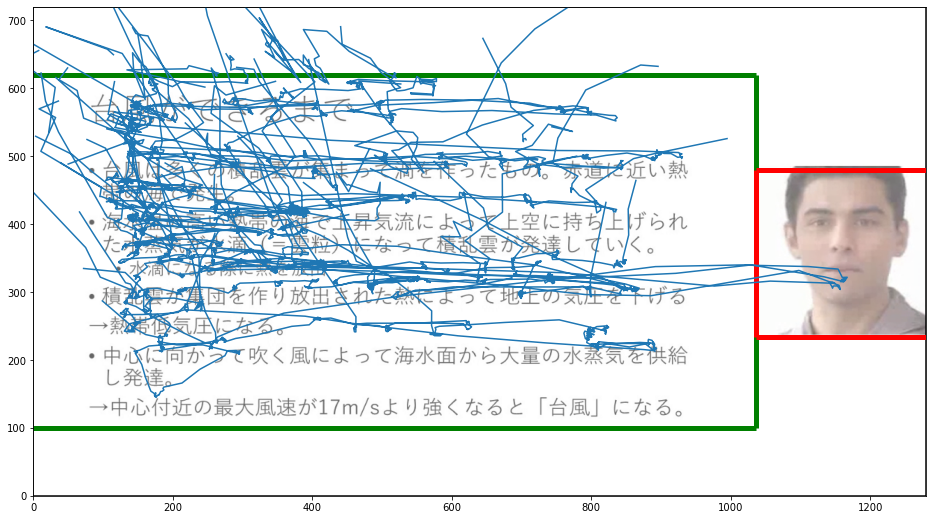

In [81]:
# 講義画面（画像）に視線を合わせる（ずれてそう）
def get_frame(video, frame_num):
    cap = cv2.VideoCapture(video)
    if not cap.isOpened():
        return
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    # if ret:
    #     cv2.imshow("window_name", frame)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return frame[:, :, [2, 1, 0]]
    # return cv2.imencode(".png", frame[:, :, [2, 1, 0]])[1].tobytes()
video = '../data/video/ty4.mp4'
color = get_frame(video, 2014)
image = Image.fromarray(color)
# ax = plt.imshow(image)

fig = plt.figure(figsize=(16, 9))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)
extent = (0, 1280, 0, 720)

ax.plot(dfgch.loc[:, "eye_x"], dfgch.loc[:, "eye_y"])

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
plt.vlines(0, 0, 720)
plt.vlines(1280, 0, 720)
plt.hlines(0, 0, 1280)
plt.hlines(720, 0, 1280)
# 緑がスライドの範囲
plt.vlines(1036, 100, 620, colors="green", linewidth=5)
plt.hlines(100, 0, 1036, colors="green", linewidth=5)
plt.hlines(620, 0, 1036, colors="green", linewidth=5)
# 赤が講師の範囲
plt.vlines(1036, 233, 480, colors="red", linewidth=5)
plt.hlines(233, 1036, 1280, colors="red", linewidth=5)
plt.hlines(480, 1036, 1280, colors="red", linewidth=5)

ax.imshow(image, extent=extent, aspect='auto', alpha=0.6)
plt.show()

# fig = plt.figure(figsize=(16, 9))
# # fbeg = 600
# # fend = 1000
# # plt.plot(dfg[user_id].loc[fbeg:fend, "eye_x"], dfg[user_id].loc[fbeg:fend, "eye_y"])
# plt.vlines(0, 0, 720)
# plt.vlines(1200, 0, 720)
# plt.hlines(0, 0, 1200)
# plt.hlines(720, 0, 1200)
# # 緑がスライドの範囲
# plt.vlines(1036, 100, 620, colors="green", linewidth=5)
# plt.hlines(100, 0, 1036, colors="green", linewidth=5)
# plt.hlines(620, 0, 1036, colors="green", linewidth=5)
# # 赤が講師の範囲
# plt.vlines(1036, 213, 480, colors="red", linewidth=5)
# plt.hlines(213, 1036, 1200, colors="red", linewidth=5)
# plt.hlines(480, 1036, 1200, colors="red", linewidth=5)
# plt.plot(dfg[user_id].loc[:, "eye_x"], dfg[user_id].loc[:, "eye_y"])


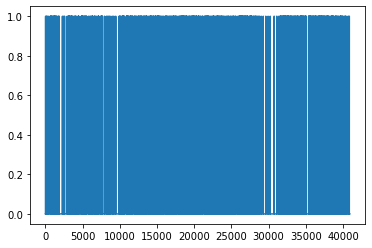

In [12]:
plt.plot(dfg[user_id]["eye_x"].isna())

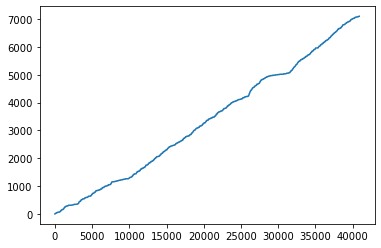

In [14]:
#数値があると上がる
bools = dfg[user_id]["eye_x"].isna().values
plt.plot(bools.cumsum())

In [77]:
# 何用か忘れた
startend = pd.read_csv('../data/sys_clock2023.csv') # 9_slide_timeで作成
startend["user_id"] = startend["user_id"]-1
user_id = 2
startend_df = startend[startend["user_id"]==user_id].reset_index(drop=True)
dfgch = dfg[user_id]
dfgch = dfgch[dfgch["sys_clock"]>=startend_df["t_start"][1]]
dfgch = dfgch[dfgch["sys_clock"]<=startend_df["t_end"][1]]
# print(dfg["sys_clock"])
# startend_df

In [69]:
test = []
for i in check:
    test.append(df2_x.iloc[i])
    test.append(df2_x.iloc[i+1])
dftest = pd.DataFrame(test)
dftest

,dt_sec,msec,eye_x,eye_y,leye_x,leye_y,reye_x,reye_y,dev_clock,sys_clock
220,2.023112e+13,208.0,936.207237,334.120771,0.721325,0.449763,0.741499,0.478350,308439825.0,1.010448e+11
221,2.023112e+13,218.0,1038.140030,334.089786,0.801924,0.447583,0.820170,0.480445,308450928.0,1.010448e+11
340,2.023112e+13,654.0,1080.365486,348.362346,0.840364,0.473125,0.847707,0.494549,309885971.0,1.010462e+11
341,2.023112e+13,665.0,1000.518799,338.321829,0.755940,0.460295,0.807371,0.479488,309897074.0,1.010462e+11
1429,2.023112e+13,26.0,940.853882,326.712381,0.748564,0.450493,0.721520,0.457041,322258377.0,1.010586e+11
...,...,...,...,...,...,...,...,...,...,...
30241,2.023112e+13,33.0,620.795631,469.669583,0.434419,0.637876,0.535574,0.666762,651472884.0,1.013878e+11
36377,2.023112e+13,929.0,918.917046,285.565256,0.711749,0.382177,0.724058,0.411060,721368276.0,1.014577e+11
36378,2.023112e+13,941.0,1046.423759,306.004772,0.801336,0.408728,0.833701,0.441285,721379379.0,1.014577e+11
36415,2.023112e+13,351.0,1092.146072,305.952544,0.851259,0.409030,0.855219,0.440838,721790195.0,1.014581e+11


In [76]:
# # 読み込めているかチェック
# if not cap.isOpened():
#     sys.exit()

# # 各フレームの注視点を重畳表示
# # while True:
# for t in range(0, T - 1):
#     # 現在のフレームの位置
#     cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
#     assert(t == cur_frame)
#     # ret：読み込めたかどうか、frame：画像
#     ret, frame = cap.read()
#     # 動画の最後
#     if not ret:
#         print('no more frame ...')
#         break

#     # このフレームのシステム時間を取得（retrieve the system time of this frame）
#     eyeseq = []
#     for i in range(len(dfv)):
#         print(i)
#         t_beg = dfv[i].loc[t, 'sys_clock']
#         t_end = dfv[i].loc[t + 1, 'sys_clock']
#         _eyeseq = dfg[i].loc[(dfg[i]['sys_clock'] >= t_beg) & (dfg[i]['sys_clock'] < t_end),
#             ['eye_x', 'eye_y']].values
#         print(_eyeseq)
#         print(f"!!!{t_end}!!!")
#         eyeseq.append(_eyeseq)
#     # 結合（list→array）
#     eyeseq = np.concatenate(eyeseq)  # list of array to array
#     eyeseq[:, 0] = eyeseq[:, 0] * width
#     eyeseq[:, 1] = eyeseq[:, 1] * height
#     for eyept in eyeseq:
#         if any(np.isnan(eyept)):
#             continue
#         print(f't: {t} --- ', eyept.astype(np.int64))
#         cv2.circle(frame, tuple(eyept.astype(np.int64)), ptsize, ptcolor, -1)

#     cv2.imshow(window_name, frame)
#     if cv2.waitKey(delay) & 0xFF == ord('q'):
#         break
#     # elif cv2.waitKey(delay) & 0xFF == ord('s'):
#     #     cv2.imwrite("../capture_{}.png".format(t), frame)

# cv2.destroyWindow(window_name)

# cap.release()

In [ ]:
# # 台風視点確認
# alist = [[563, 730, 105, 312, 465, 387], [1778, 1995, 2325, 551, 520, 627], 
#          [2300, 2413, 645, 203, 780, 276], [3793, 3903, 75, 422, 435, 492], 
#         [4510, 4692, 75, 248, 538, 319], [4839, 4935, 498, 323, 635, 396], 
#         [5470, 5895, 345, 399, 568, 471], [5470, 5895, 315, 475, 450, 549], 
#         [8740, 8893, 165, 270, 510, 340], [10508, 10665, 375, 207, 820, 278], 
#         [10840, 10970, 75, 281, 390, 356], [11830, 11955, 75, 281, 390, 356], 
#         [12308, 12435, 135, 237, 330, 309]]
# c = 0
# for l in alist:
#     c += 1
#     for i in range(len(eyefpath)-1):
#         dfm = pd.merge(dfg[i], dfv[i], on=["dt_sec","msec"])
#         dfm = dfm[dfm["counter"]>=l[0]]
#         dfm = dfm[dfm["counter"]<=l[1]]
#         dfm = dfm[dfm["eye_x"]>=l[2]]
#         dfm = dfm[dfm["eye_y"]>=l[3]]
#         dfm = dfm[dfm["eye_x"]<=l[4]]
#         dfm = dfm[dfm["eye_y"]<=l[5]]
#         if len(dfm) > 1:
#             print(c, "-", i, "個目", "\n", dfm.iloc[[0, len(dfm)-1]][["dt_sec", "msec"]])
#         elif len(dfm) == 1:
#             print(c, "-", i, "個目", "\n", dfm[["dt_sec", "msec"]])

In [ ]:
# 台風視点確認
# alist = [[563, 730, 105, 312, 465, 387, 1], [1778, 1995, 235, 551, 520, 627, 2], [2300, 2413, 645, 203, 780, 276, 3], [3793, 3903, 75, 422, 435, 492, 4], [4510, 4692, 75, 248, 538, 319, 5], [4839, 4935, 498, 323, 635, 396, 6], [5470, 5895, 345, 399, 568, 471, 7], [5470, 5895, 315, 475, 450, 549, 8], [8740, 8893, 165, 270, 510, 340, 9], [10508, 10665, 375, 207, 820, 278, 10],[10840, 10970, 75, 281, 390, 356, 11], [11830, 11955, 75, 281, 390, 356, 12], [12308, 12435, 135, 237, 330, 309, 13]]
# オーストラリア
# alist = [[668, 1187, 295, 286, 442, 354, 1], [668, 1187, 348, 319, 508, 387, 2], [1628, 1725, 74, 114, 274, 187, 3], [2647, 2745, 377, 341, 658, 415, 4], [3339, 3465, 133, 271, 581, 342, 5], [4895, 5085, 785, 525, 925, 592, 6], [4895, 5085, 126, 553, 460, 621, 7], [6365, 6495, 765, 314, 960, 382, 8], [6365, 6495, 79, 342, 150, 412, 9], [11048, 11205, 495, 193, 841, 262, 10], [11497, 11773, 505, 290, 695, 361, 11], [12847, 12943, 225, 400, 395, 470, 12], [14378, 14564, 375, 219, 843, 292, 13]]
# 都市工学
# alist = [[245, 332, 230, 203, 620, 280, 1], [1175, 1333, 70, 280, 315, 200, 2], [1928, 2013, 255, 411, 360, 482, 3], [5467, 5683, 550, 204, 950, 276, 4], [6757, 6885, 400, 355, 620, 430, 5], [9638, 9795, 765, 225, 885, 299, 6], [11528, 11623, 600, 310, 880, 387, 7], [12758, 12916, 380, 248, 520, 319, 8], [14440, 14594, 765, 443, 930, 515, 9], [15008, 15133, 425, 290, 971, 359, 10]]

In [ ]:
# df3way = []
# for n in range(len(eyefpath)):
#     df3w = pd.DataFrame(columns={"l_or_s_or_b"})
#     for i in range(len(dfg[n])):
#         # スライド
#         if dfg[n]["eye_x"][i]>1036 and dfg[n]["eye_y"][i]>213 and dfg[n]["eye_y"][i]<500:
#             df3w.loc[i] = 1
#         # 講師
#         elif dfg[n]["eye_x"][i]<1036 and dfg[n]["eye_y"][i]>80 and dfg[n]["eye_y"][i]<640:
#             df3w.loc[i] = 2
#         else:
#             df3w.loc[i] = 0
#     df3way.append(df3w)
#     print(n)

In [13]:
# a_l = []
# for i in range(len(dfg)):
#     dfgc = dfg[i].copy().reset_index()
#     alis = []
# #     print(len(dfgc))
#     for l in alist:
#         al = []
#         dfgcc = dfgc[dfgc["sys_clock"]>=dfv[i]["sys_clock"][l[0]]]
#         dfgcc = dfgcc[dfgcc["sys_clock"]<=dfv[i]["sys_clock"][l[1]]]
#         al.append(dfgcc["index"][0:1])
#         al.append(dfgcc["index"][len(dfgcc)-1:len(dfgcc)])
#         alis.append(al)
# #         print(alis)
#     a_l.append(alis)

In [14]:
# for i in range(len(df3way)):
#     imlist = a_l[i]
#     plt.plot(df3way[i].reset_index()["index"][1501:3000], df3way[i].reset_index()["l_or_s_or_b"][1501:3000])
#     for n in range(len(imlist)):
#         if int(imlist[n][0])>=3000:
#             continue
#         plt.vlines(imlist[n][0], 0, 2, color='r', linestyles='dotted')
#         plt.vlines(imlist[n][1], 0, 2, color='r', linestyles='dotted')
#     plt.xlabel("フレーム数")
#     plt.ylabel("その他  　         　講師　   　　　  スライド")
#     plt.title("学習者の視線（1501～3000）")
#     # plt.savefig("学習者の視線.jpg")
#     plt.show()